In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# silence Future Warning
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [3]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


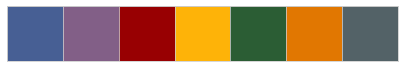

In [5]:
# import custom palette
import my_palette as mp

In [6]:
# read in actor dataset
df = pd.read_json('capstone1_ds.json')

In [7]:
# observe dimensionality of dataset
df.shape

(11693, 28)

In [8]:
# separate data into features and target
X = df.drop('actor_value', axis=1)
y = df['actor_value']

In [9]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [10]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

In [11]:
gpu_params = {'tree_method':'gpu_hist', 
              'predictor':'gpu_predictor',
              'sampling_method':'gradient_based', 
              'deterministic_histogram':'False'}

In [12]:
def get_base_model(features, target):
    """Return base XGBoost regressor model"""
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=27, n_jobs=-1)
    model.fit(features, target)
    
    return model

In [13]:
def get_params(model):
    """Return hyperparameters of interest from regressor"""
    series = pd.Series(
        model.get_params(), name='model_params').drop(
        ['base_score', 'booster', 'importance_type', 'missing', 'n_jobs', 'nthread', 
         'objective', 'random_state', 'scale_pos_weight', 'seed', 'silent', 'verbosity'])
    
    return series

In [14]:
# instantiate base model for given target and get parameters
base_model = get_base_model(X_train, y_train)
get_params(base_model)

colsample_bylevel      1
colsample_bynode       1
colsample_bytree       1
gamma                  0
learning_rate        0.1
max_delta_step         0
max_depth              3
min_child_weight       1
n_estimators         100
reg_alpha              0
reg_lambda             1
subsample              1
Name: model_params, dtype: object

In [15]:
def get_cv_adj_r2(features, target, model):
    """Return cross-validation average adjusted R2 score and adjusted R2 score range"""
    cv_results = cross_val_score(model, features, target, cv=10, n_jobs=-1)
    
    n = features.shape[0]
    p = features.shape[1]
    adj_r2 = 1 - (1 - cv_results) * ((n - 1)  / (n - p - 1))

    # get range of scores
    results_range = (np.min(adj_r2), np.max(adj_r2))
    # get average score and round to 5 decimal places
    ave_result = np.mean(adj_r2)

    return f'Average Adjusted R2 Score: {ave_result:.4f}, Range: {results_range[0]:.4f}, {results_range[1]:.4f}'

In [16]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, base_model)

'Average Adjusted R2 Score: 0.8973, Range: 0.8459, 0.9193'

In [17]:
def get_cv_rmse(features, target, model):
    """Return CV average root mean squared error and root mean square error range"""
    cv_results = cross_val_score(model, features, target, 
                                 scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
#    global results
    results = np.round(np.sqrt(cv_results * -1), 5)
    results_range = (np.min(results), np.max(results))
    ave_result = np.round(np.sqrt(np.mean(cv_results) * -1), 5)
        
    return f'Average RMSE: ${ave_result:,.2f}, Range: (${results_range[0]:,.2f}, ${results_range[1]:,.2f})'

In [18]:
# get cross-validation results
get_cv_rmse(X_train, y_train, base_model)

'Average RMSE: $391,175,724.85, Range: ($323,736,474.98, $508,567,046.03)'

In [19]:
def plot_predictions(features, target, model):
    """Return plot of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.scatterplot(y_test, model.predict(X_test), color=mp.colors(1))
    sns.regplot(y_test, model.predict(X_test), color=mp.colors(6), scatter=False)
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.title("Ground Truth vs Predicted");

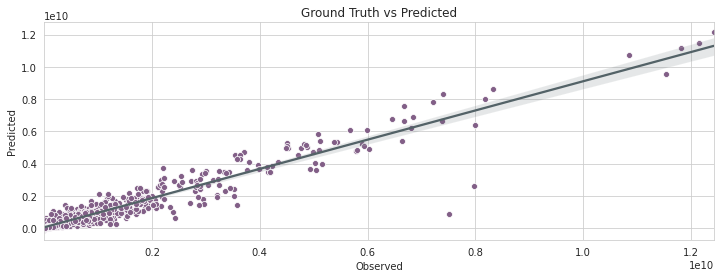

In [20]:
# plot observed target vs. predictions for out of the box rfr model
plot_predictions(X_train, y_train, base_model)

In [21]:
def plot_residuals(features, target, model):
    """Return plot of predictions vs.residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.residplot(
        model.predict(X_test), y_test, lowess=True, scatter_kws={'s':10}, 
        color=mp.colors(2), line_kws={'linewidth':3})
    
    plt.xlabel('Predicted Actor Value')
    plt.ylabel('Residuals')
    
    plt.title("Predicted vs Residuals");

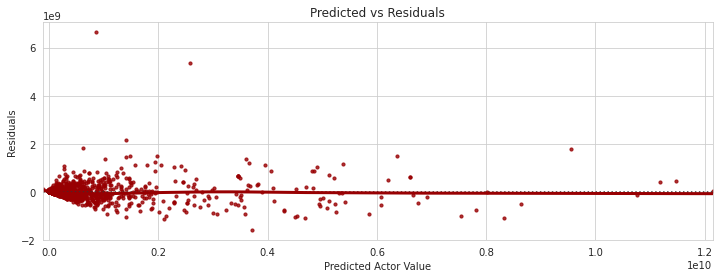

In [22]:
# plot predictions vs. residuals for out of the box rfr model
plot_residuals(X_train, y_train, base_model)

In [23]:
def plot_residual_distribution(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    plt.ylim(0, 6e-9)
    
    sns.distplot(
        (y_test - model.predict(X_test)), bins=300, rug=True, axlabel='Residuals', 
        color=mp.colors(4))

    plt.ylabel('Frequency')

    plt.title('Distribution of Residuals');

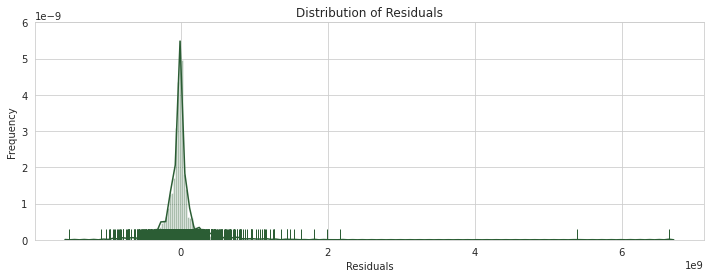

In [24]:
# plot residuals distribution for out of the box rfr model
plot_residual_distribution(X_train, y_train, base_model)

In [25]:
def plot_feature_importance(model):
    """Plots the features by importance to model"""
    ax = xgb.plot_importance(base_model)
    ax.figure.set_size_inches(12, 8)
    ax.plot();

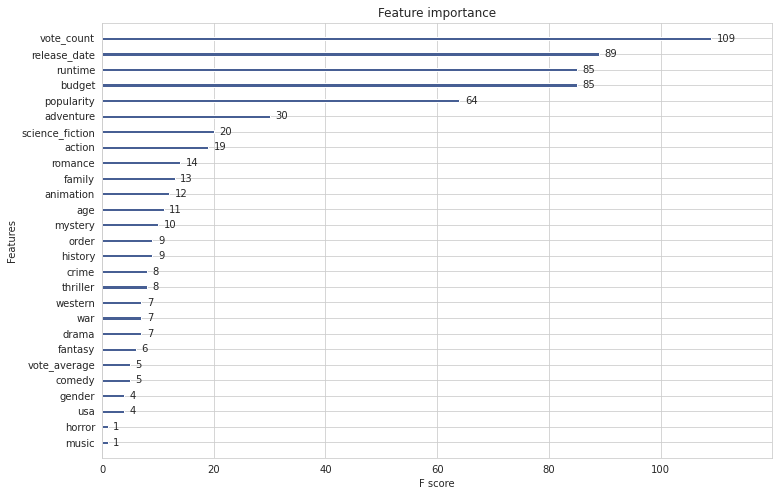

In [26]:
plot_feature_importance(base_model)

In [27]:
def plot_hp(train_scores, test_scores, param_lst):
    """Plots average errors and standard deviations over range of one hyperparameter"""
    # get scores stats
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # plot training scores
    sns.lineplot(x=param_lst, y=train_scores_mean, label="Training Score",
                 color=mp.colors(5), lw=2)
    plt.fill_between(param_lst, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color=mp.colors(5), lw=2)
    # plot test scores
    sns.lineplot(x=param_lst, y=test_scores_mean, label="Test Score",
                 color=mp.colors(0), lw=2)
    plt.fill_between(param_lst, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color=mp.colors(0), lw=2)
    
    plt.ylabel("RMSE", fontsize=15)
    
    plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5, fontsize='large')

In [28]:
def plot_hyperparameters(features, target, model, grid):
    """Plots CV results over range of each hyperparameter"""
    # establish figure height
    num_subplots = 0
    for param_lst in grid.values():
        if len(param_lst) > 1:
              num_subplots += 1
    fig_height = num_subplots * 4
    # set subplots grid
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot errors over range of each hyperparameter
    count = 0   
    for param, param_lst in grid.items():
        # only score parameters that were given a range
        if len(param_lst) > 1:
            # get CV scores
            train_scores, test_scores = validation_curve(
                model, features, target, param_name=param, param_range=param_lst, 
                cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
            # convert scores to root-mean-square error
            train_rmse = np.sqrt(train_scores * -1)
            test_rmse = np.sqrt(test_scores * -1)
            # plot errors over range one hyperparameter
            count += 1
            plt.subplot(num_subplots, 1, count)
            
            plt.xlim(np.min(param_lst), np.max(param_lst))
            
            plot_hp(train_rmse, test_rmse, param_lst)
            
            plt.xlabel(param, fontsize=15)  
    plt.suptitle("Validation Curves with XGB", y=1.04, fontsize=20)
    plt.tight_layout();

I'll observe the errors for a various numbers of trees and some shrinkage values.

In [29]:
# create parameter search grid
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(5, 300, num=60)]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

n_estimators [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 600 | elapsed:   18.4s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   36.6s finished


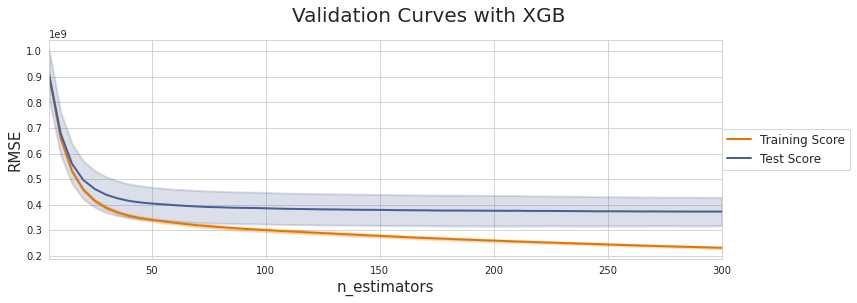

In [30]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

In [31]:
# create parameter search grid
param_grid = {
    'learning_rate': np.linspace(0.01, 0.2, 20)
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

learning_rate [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2 ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 200 | elapsed:    4.8s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.3s finished


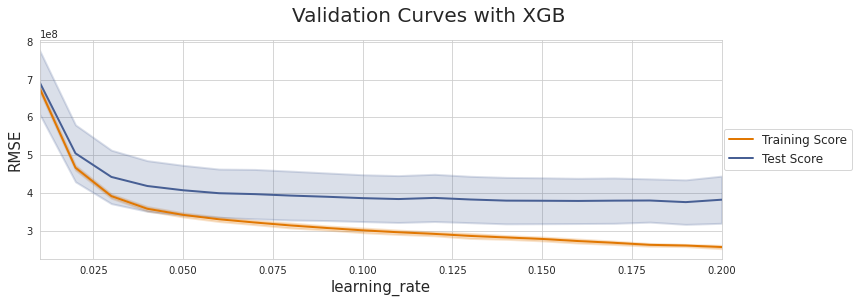

In [32]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

Some literature suggests to begin by finding the best product of number of trees and learning rate.<br>
I will call this product the model's tree flow.

I'll target different numbers of trees, while searching over a range of tree flows.

In [33]:
# create tree flow search grid for 100 trees
num_trees = 10
tree_flow_range = np.linspace(0.1, 1, 10)
# create parameter search grid
param_grid = {
    'learning_rate': (tree_flow_range / num_trees).tolist(),
    'n_estimators': [num_trees]
}

print('tree_flow', tree_flow_range)
for param, param_lst in param_grid.items():
    print(param, param_lst)

tree_flow [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
learning_rate [0.01, 0.02, 0.030000000000000006, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_estimators [10]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


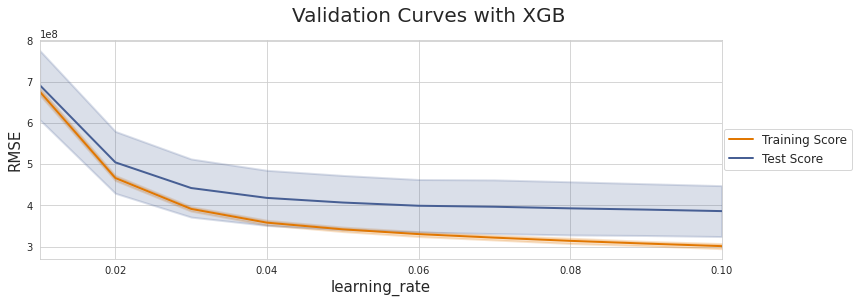

In [34]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

In [35]:
# create tree flow search grid for 100 trees
num_trees = 100
tree_flow_range = np.linspace(1, 10, 10)
# create parameter search grid
param_grid = {
    'learning_rate': (tree_flow_range / num_trees).tolist(),
    'n_estimators': [num_trees]
}

print('tree_flow', tree_flow_range)
for param, param_lst in param_grid.items():
    print(param, param_lst)

tree_flow [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
learning_rate [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_estimators [100]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


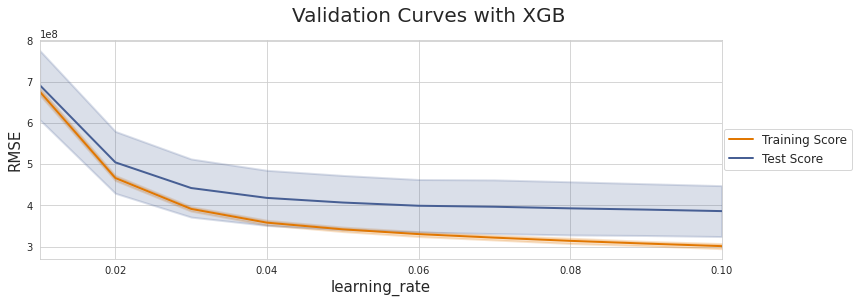

In [36]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

In [37]:
# create tree flow search grid for 500 trees
num_trees = 500
tree_flow_range = np.linspace(5, 50, 10)
# create parameter search grid
param_grid = {
    'learning_rate': (tree_flow_range / num_trees).tolist(),
    'n_estimators': [num_trees]
}

print('tree_flow', tree_flow_range)
for param, param_lst in param_grid.items():
    print(param, param_lst)

tree_flow [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]
learning_rate [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_estimators [500]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


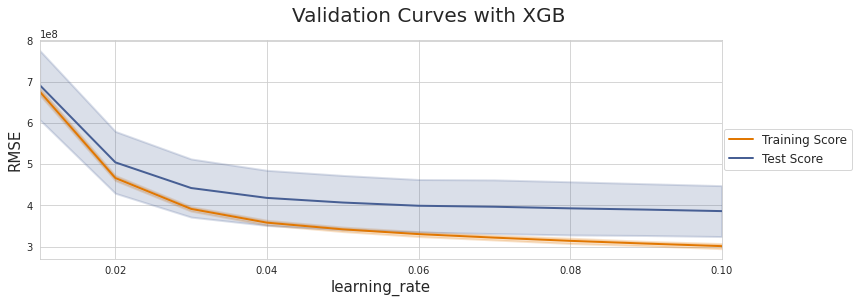

In [38]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

In [39]:
# create tree flow search grid for 1000 trees
num_trees = 1000
tree_flow_range = np.linspace(10, 100, 10)
# create parameter search grid
param_grid = {
    'learning_rate': (tree_flow_range / num_trees).tolist(),
    'n_estimators': [num_trees]
}

print('tree_flow', tree_flow_range)
for param, param_lst in param_grid.items():
    print(param, param_lst)

tree_flow [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
learning_rate [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_estimators [1000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


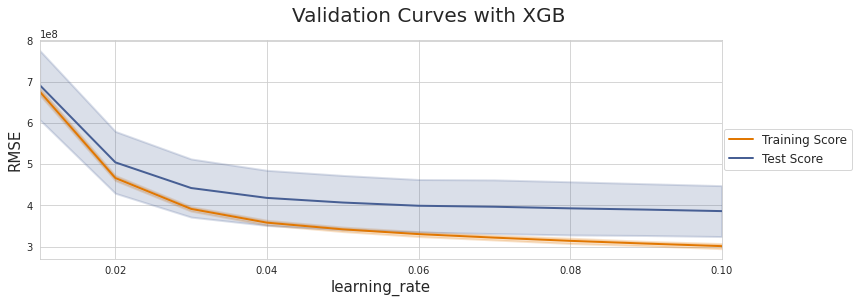

In [40]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

All 3 plots show the same results, despite the number of trees used.<br>
The optimal learning rate is independent of the number of trees used for this dataset.

In [ ]:
# create initial ranges to consider for parameter search grid
param_grid_1 = {
#    'colsample_bylevel': np.linspace(0.1, 1, 10), 
#    'colsample_bynode': np.linspace(0.1, 1, 10),
#    'colsample_bytree': np.linspace(0.1, 1, 10), 
#    'gamma': [int(x) for x in np.linspace(1, 70, num=15)],
#    'learning_rate': np.linspace(0.01, 0.2, 20),
#    'max_delta_step': [int(x) for x in np.linspace(5, 100, num=20)],
#    'max_depth': [int(x) for x in np.linspace(1, 10, 10)],
#    'min_child_weight': [int(x) for x in np.linspace(2, 100, num=11)],
#    'n_estimators': [int(x) for x in np.linspace(5, 300, num=60)],
#    'reg_alpha': [int(x) for x in np.linspace(5, 100, num=20)],
#    'reg_lambda': np.linspace(0.001, 20.0),
#    'subsample': np.linspace(0.1, 1, 10)
}
for param, param_lst in param_grid_1.items():
    print(param, param_lst)

In [ ]:
# first run plotting function
def plot_hyperparameters(features, target, model, grid):
    """Plots CV results for each hyperparameter"""
    count = 0
    n_hp = len(grid.items())
    fig, axes = plt.subplots(nrows=n_hp, figsize=(12, 12))
    for param, param_lst in grid.items():
        # get CV scores
        train_scores, test_scores = validation_curve(
            model, features, target, param_name=param, param_range=param_lst, 
            cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
        # convert scores to root-mean-square error
        train_rmse = np.sqrt(train_scores * -1)
        test_rmse = np.sqrt(test_scores * -1)
        count += 1
        plt.subplot(n_hp, 1, count)
        plt.xlim(np.min(param_lst), np.max(param_lst))
        plot_hp(train_rmse, test_rmse, param_lst)
        plt.xlabel(param, fontsize=15)  
    plt.suptitle("Validation Curves with XGB", y=1.04, fontsize=20)
    plt.tight_layout();